In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import Voronoi, voronoi_plot_2d
import math
from numpy import array

In [3]:
# code adapted from https://gist.github.com/pv/8036995
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

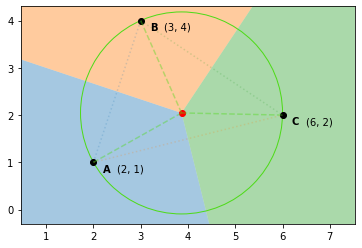

In [7]:
# Array of three random points
points = array([[2,1], [3,4], [6,2]], int)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot the regions
regions, vertices = voronoi_finite_polygons_2d(vor)

# color the cells
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)
    
# plot the points 
plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 1.3, vor.max_bound[1] + 0.3)


pt = ['A','B','C']

# transpose the array then zip the coordinates so get a tuple (x,y) as text
tpoints = zip(*points.transpose())

# Anootate the plot with labels A(x,y)
for i, txt in enumerate(tpoints):
    plt.annotate(pt[i], (points[i][0]+0.2, points[i][1]-0.2),weight='bold',)
    plt.annotate(txt, (points[i][0]+0.5, points[i][1]-0.2))

# connect the points 
plt.plot([points[0][0],points[1][0]], [points[0][1],points[1][1]],  linestyle='dotted', alpha = 0.2)
plt.plot([points[0][0],points[2][0]], [points[0][1],points[2][1]], linestyle='dotted', alpha = 0.2)
plt.plot([points[1][0],points[2][0]], [points[1][1],points[2][1]], linestyle='dotted', alpha = 0.2)


# vertices [0,0] and vertices[0,1] are the coordinates of the vertex where the three 
# perpedicular bsectors intersect
plt.plot(vertices[0,0], vertices[0,1], 'ro')

# plot a line connecting the vertex to the points
plt.plot([vertices[0,0],points[0][0]], [vertices[0,1],points[0][1]],color='#4edb18',linestyle='dashed', alpha = 0.4)
plt.plot([vertices[0,0],points[1][0]], [vertices[0,1],points[1][1]],color='#4edb18', linestyle='dashed', alpha = 0.4)
plt.plot([vertices[0,0],points[2][0]], [vertices[0,1],points[2][1]],color='#4edb18',linestyle='dashed', alpha = 0.4)

# All three points are equidistant from the vertex thus the vertex is the center
# of a circle passing throgh the three points therefore the radius of the circle 
#is the distance between the vertex to any of the points 
rad =  math.sqrt( (points[0,0] - vertices[0,0])**2 + (points[0,1] - vertices[0,1])**2 )
c= plt.Circle(( vertices[0,0], vertices[0,1] ), rad ,fill = False, edgecolor = '#4edb18', linestyle ='solid', linewidth = 1)
plt.gca().add_artist(c)

plt.show()
